# IPF Test
#### Evan Faulkner
#### 2/18/2021

### Notation and algorithm described in:
#### https://dspace.mit.edu/handle/1721.1/37970

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

### Generate Random Single Line OD Problem

In [2]:
N_stops = 8 # number of stops on the bus line
i_max = 20 # max flow from i to j
T_ij = np.triu(np.random.randint(0,i_max+1,size=(N_stops,N_stops)),1) # true OD matrix, upper triangular, zero main diagonal
M_i = np.sum(T_ij,1) # boarding counts at stop i
M_j = np.sum(T_ij,0) # alighting counts at stop j
mask = T_ij>0 # mask off zero elements
#t_ij = np.triu(np.ones((N_stops,N_stops)),1)*mask # seed matrix (not sure what to do)
t_ij = np.maximum(T_ij - np.triu(np.random.randint(0,math.ceil(0.7*i_max),size=(N_stops,N_stops)),1),np.ones((N_stops,N_stops)))*mask

### IPF Implementation

In [3]:
eps = 1e-3 # stopping condition
delta = 1 # difference between the last 2 iterations
a_i = M_i/np.sum(t_ij,1) # a_i is the row factor, initialized with b_j^0=1
a_i[np.isnan(a_i)]=0
a_i[a_i<1] = 1
a_i = np.expand_dims(a_i,1)
b_j = M_j/np.sum(a_i*t_ij,0) # b_j is the column factor, initialized with a_i^0
b_j[np.isnan(b_j)]=0
b_j[b_j<1] = 1
b_j = np.expand_dims(b_j,1)

T_hat = np.zeros((N_stops,N_stops))

while True:
    if delta>eps:
        a = M_i/np.sum(b_j[:,-1].T*t_ij,1)
        a[np.isnan(a)] = 0
        a[a<1] = 1
        a = np.expand_dims(a,1)
        b = M_j/np.sum(a*t_ij,0)
        b[np.isnan(b)] = 0
        b[b<1] = 1
        b = np.expand_dims(b,1)
        delta = np.abs(np.mean(a-a_i[:,-1])+np.mean(b-b_j[:,-1]))
        #print('delta = ',delta)
        a_i = np.c_[a_i,a]
        b_j = np.c_[b_j,b]
    else:
        print(f'a_i = {np.round(a_i[:,-1], 2)}', f'\nb_j = {np.round(b_j[:,-1], 2)}')
        break
    
for i in range(N_stops):
    for j in range(N_stops):
        T_hat[i,j] = a_i[i,-1]*b[j,-1]*t_ij[i,j] # compute the estimated OD matrix from the final a_i, b_j, and seed entries

a_i = [1.   1.   2.47 1.27 1.   3.65 3.89 1.  ] 
b_j = [1.   2.5  1.58 1.   1.29 2.23 1.99 1.03]


<ipython-input-3-a54e2a7dda29>:3: RuntimeWarning: invalid value encountered in true_divide
  a_i = M_i/np.sum(t_ij,1) # a_i is the row factor, initialized with b_j^0=1
<ipython-input-3-a54e2a7dda29>:7: RuntimeWarning: invalid value encountered in true_divide
  b_j = M_j/np.sum(a_i*t_ij,0) # b_j is the column factor, initialized with a_i^0
<ipython-input-3-a54e2a7dda29>:16: RuntimeWarning: invalid value encountered in true_divide
  a = M_i/np.sum(b_j[:,-1].T*t_ij,1)
<ipython-input-3-a54e2a7dda29>:20: RuntimeWarning: invalid value encountered in true_divide
  b = M_j/np.sum(a*t_ij,0)


In [4]:
print(f'Elementwise Error in T_hat:\n {np.round((T_ij-T_hat),2)}')
print(f'Relative error in T_hat: {np.round(np.linalg.norm(T_ij-T_hat)/np.linalg.norm(T_ij),2)}')

Elementwise Error in T_hat:
 [[  0.     0.     4.42   1.     9.82  -4.09 -14.78   1.91]
 [  0.     0.    -4.42   0.     0.     0.77   1.01  -0.03]
 [  0.     0.     0.    -7.83   1.8    1.48   5.09  -0.54]
 [  0.     0.     0.     0.   -11.63   7.16   6.89  -2.47]
 [  0.     0.     0.     0.     0.    -5.32   1.04   1.88]
 [  0.     0.     0.     0.     0.     0.     0.75  -0.75]
 [  0.     0.     0.     0.     0.     0.     0.    -0.  ]
 [  0.     0.     0.     0.     0.     0.     0.     0.  ]]
Relative error in T_hat: 0.52


In [5]:
print(f'Elementwise Error in Rounded T_hat:\n {T_ij-T_hat.astype(int)}')
print(f'Relative error in rounded T_hat: {np.round(np.linalg.norm(T_ij-T_hat.astype(int))/np.linalg.norm(T_ij),2)}')

Elementwise Error in Rounded T_hat:
 [[  0   0   5   1  10  -4 -14   2]
 [  0   0  -4   0   0   1   2   0]
 [  0   0   0  -7   2   2   6   0]
 [  0   0   0   0 -11   8   7  -2]
 [  0   0   0   0   0  -5   2   2]
 [  0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]
Relative error in rounded T_hat: 0.52


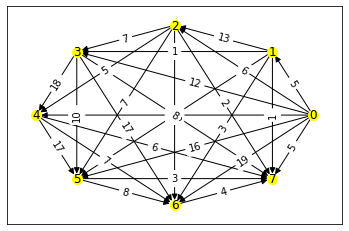

In [6]:
G = nx.from_numpy_matrix(T_ij, create_using=nx.DiGraph)
G_hat = nx.from_numpy_matrix(np.round(T_hat,2), create_using=nx.DiGraph)

options = {
    'node_color': 'yellow',
    'node_size': 100,
    'width': 1,
    'arrowstyle': '-|>',
    'arrowsize': 12,
}
pos=nx.circular_layout(G)
nx.draw_networkx(G, pos, arrows=True, **options)
labels = nx.get_edge_attributes(G,'weight')
l=nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)

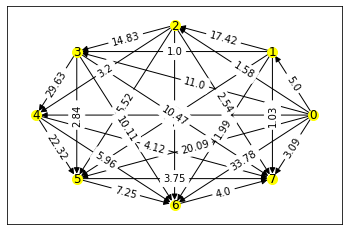

In [7]:
pos=nx.circular_layout(G_hat)
nx.draw_networkx(G_hat, pos, arrows=True, **options)
labels = nx.get_edge_attributes(G_hat,'weight')
l=nx.draw_networkx_edge_labels(G_hat,pos,edge_labels=labels,label_pos=0.5)